In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from evaluation import *
from preprocessing import *
from sklearn import preprocessing
import xgboost as xgb
import gc

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_theme(
    style="whitegrid",       # Background style ("whitegrid", "darkgrid", etc.)
    palette="deep",          # Default color palette ("deep", "muted", "bright", etc.)
    font="sans-serif",       # Font family
    font_scale=1.1,          # Scale font size slightly
    rc={"figure.figsize": (8, 5)}  # Default figure size
)

c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
dataset_path = Path("../datasets")

train_identity = pd.read_csv(dataset_path / "train_identity.csv")
train_tx = pd.read_csv(dataset_path / "train_transaction.csv")


In [53]:
train_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')

In [54]:

test_identity = pd.read_csv(dataset_path / "test_identity.csv")
test_tx = pd.read_csv(dataset_path / "test_transaction.csv")

test_all_cols = pd.merge(test_tx, test_identity, on='TransactionID', how='left')


In [55]:
print(f"test_all_cols_shape: {test_all_cols.shape}")
print(f"train_all_cols_shape: {train_all_cols.shape}")

test_all_cols_shape: (506691, 433)
train_all_cols_shape: (590540, 434)


In [57]:
# Get the columns that are in test_all_cols but not in train_all_cols
columns_to_drop_test = list(set(test_all_cols.columns) - set(train_all_cols.columns))

# Get the columns that are in train_all_cols but not in test_all_cols
columns_to_drop_train = list(set(train_all_cols.columns) - set(test_all_cols.columns))
y = train_all_cols['isFraud']
# Drop those columns from test_all_cols
test_all_cols = test_all_cols.drop(columns=columns_to_drop_test)

# Drop those columns from train_all_cols
train_all_cols = train_all_cols.drop(columns=columns_to_drop_train)

# Verify the result
print(f"Columns dropped from test_all_cols: {columns_to_drop_test}")
print(f"Columns dropped from train_all_cols: {columns_to_drop_train}")
print(f"Remaining columns in test_all_cols: {test_all_cols.columns}")
print(f"Remaining columns in train_all_cols: {train_all_cols.columns}")

Columns dropped from test_all_cols: ['id-09', 'id-32', 'id-26', 'id-31', 'id-13', 'id-17', 'id-25', 'id-35', 'id-21', 'id-01', 'id-36', 'id-03', 'id-11', 'id-20', 'id-37', 'id-29', 'id-19', 'id-33', 'id-06', 'id-15', 'id-05', 'id-27', 'id-16', 'id-23', 'id-30', 'id-14', 'id-10', 'id-02', 'id-22', 'id-34', 'id-24', 'id-38', 'id-18', 'id-07', 'id-12', 'id-04', 'id-28', 'id-08']
Columns dropped from train_all_cols: ['id_15', 'id_19', 'id_06', 'id_08', 'id_17', 'id_24', 'id_34', 'id_35', 'id_23', 'id_20', 'id_28', 'isFraud', 'id_18', 'id_12', 'id_21', 'id_38', 'id_07', 'id_33', 'id_09', 'id_31', 'id_01', 'id_25', 'id_22', 'id_37', 'id_32', 'id_10', 'id_03', 'id_29', 'id_04', 'id_30', 'id_02', 'id_27', 'id_13', 'id_16', 'id_14', 'id_26', 'id_11', 'id_36', 'id_05']
Remaining columns in test_all_cols: Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'V332', 'V333', 'V334', 'V335', 'V336', 'V3

In [58]:
train_all_cols , test_all_cols = preprocess_datasets(train_all_cols, test_all_cols)

Dropping columns: ['V122', 'V108', 'V116', 'V14', 'V65', 'V110', 'V114', 'V112', 'V121', 'V118', 'V107', 'V25', 'V113', 'V109', 'V286', 'V301', 'V111', 'V120', 'V115', 'V117', 'V123', 'TransactionDT', 'V300', 'C3', 'V119', 'V305', 'V311', 'V88']
Train shape: (590540, 367)
Val shape: (506691, 367)


In [59]:
X =  train_all_cols
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [60]:
X_train, X_test  = preprocess_datasets(X_train, X_test)

Dropping columns: ['TransactionDT']
Train shape: (472432, 367)
Val shape: (118108, 367)


## XGBoost without Cross-Validation

In [61]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=17,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='auc',
    missing=-999,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
)

model.fit(X_train, y_train)

c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:41:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=17,
              max_leaves=None, min_child_weight=None, missing=-999,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [62]:
test_preds = model.predict_proba(test_all_cols)[:, 1]  

submission = test_all_cols[['TransactionID']].copy()
submission['isFraud'] = test_preds

submission.to_csv('hgb_submission.csv', index=False, header=True)


Validation Metrics:
AUC: 1.0000
Accuracy: 0.9997
Precision: 0.9912
Recall: 1.0000
F1 Score: 0.9956
Log Loss: 0.0100
Brier Score: 0.0009
Average Precision: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    455902
           1       0.99      1.00      1.00     16530

    accuracy                           1.00    472432
   macro avg       1.00      1.00      1.00    472432
weighted avg       1.00      1.00      1.00    472432

Confusion Matrix:
[[455756    146]
 [     0  16530]]

Test Metrics:
AUC: 0.9712
Accuracy: 0.9874
Precision: 0.8955
Recall: 0.7234
F1 Score: 0.8003
Log Loss: 0.0465
Brier Score: 0.0107
Average Precision: 0.8456

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.90      0.72      0.80      4133

    accuracy                           0.99    118108
   macro avg       0.94      0.86 

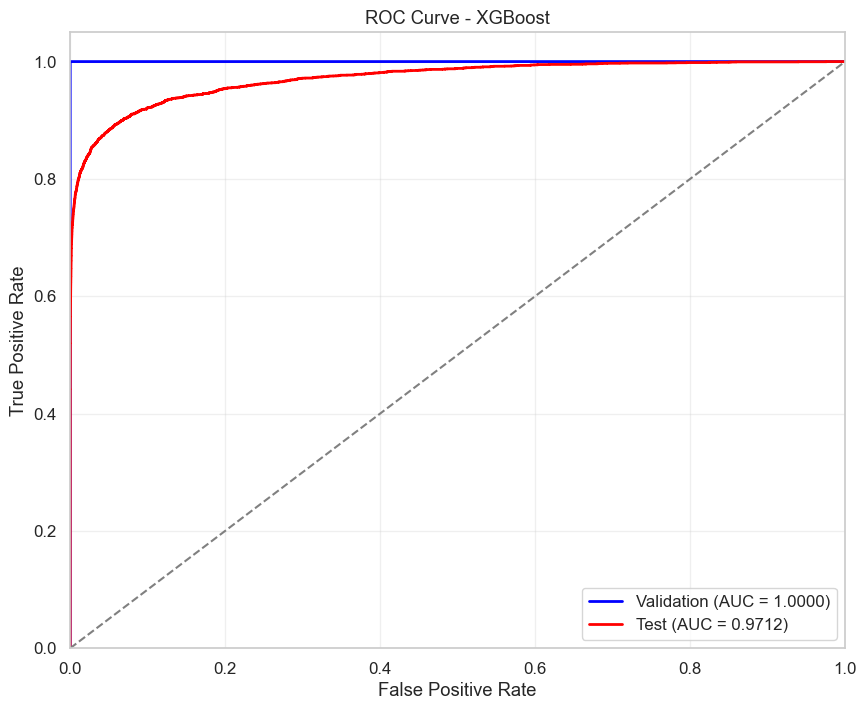

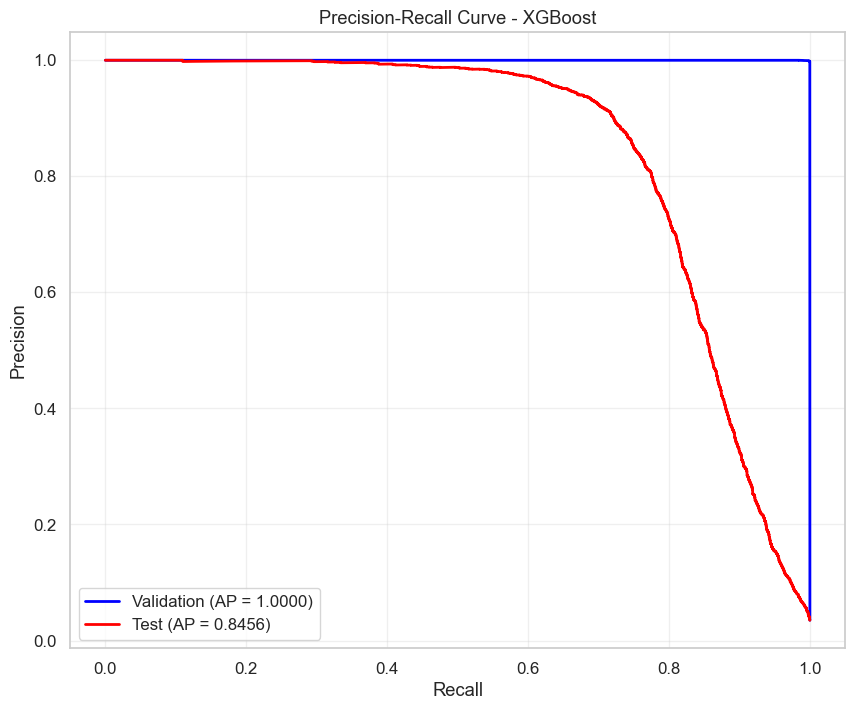

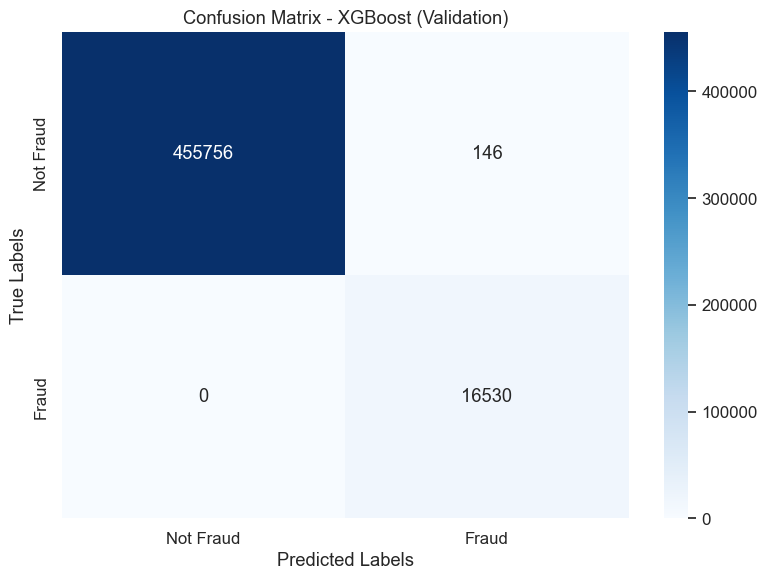

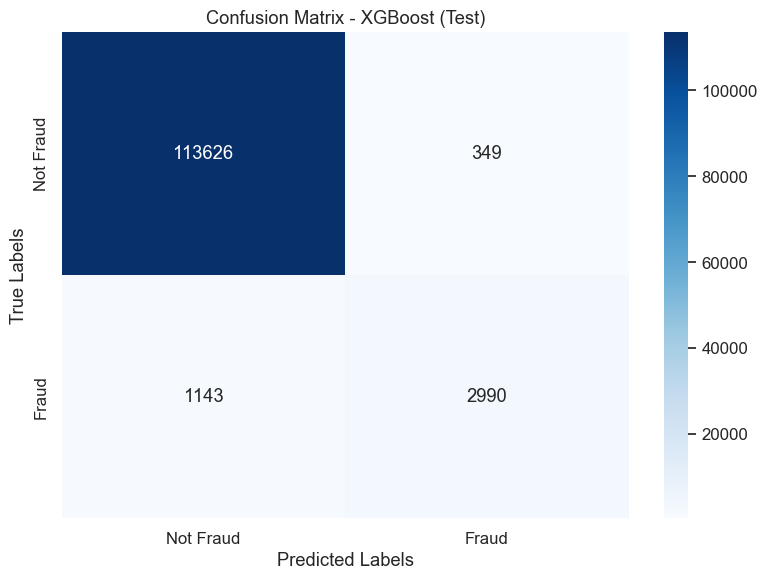

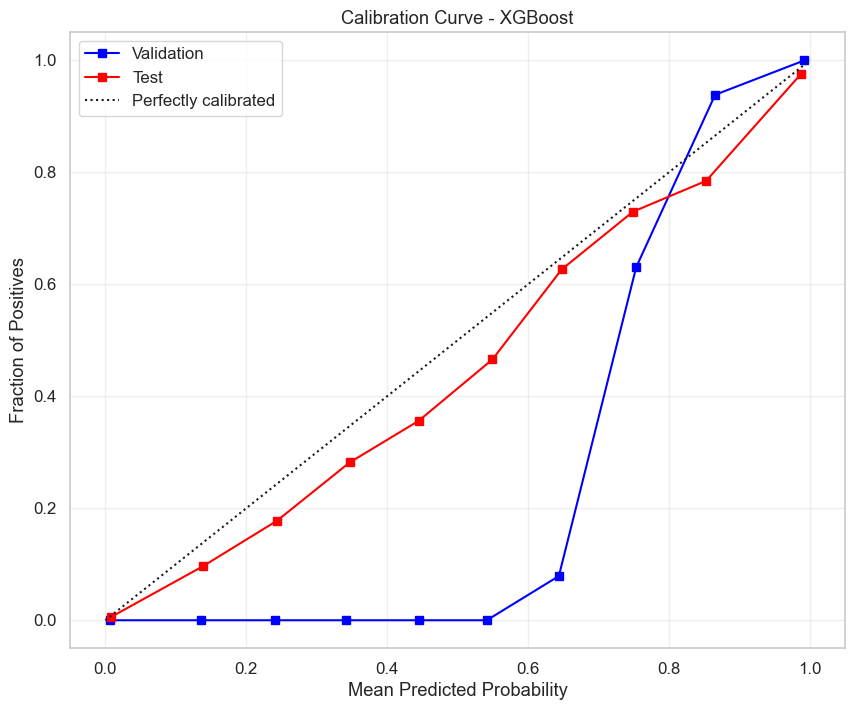

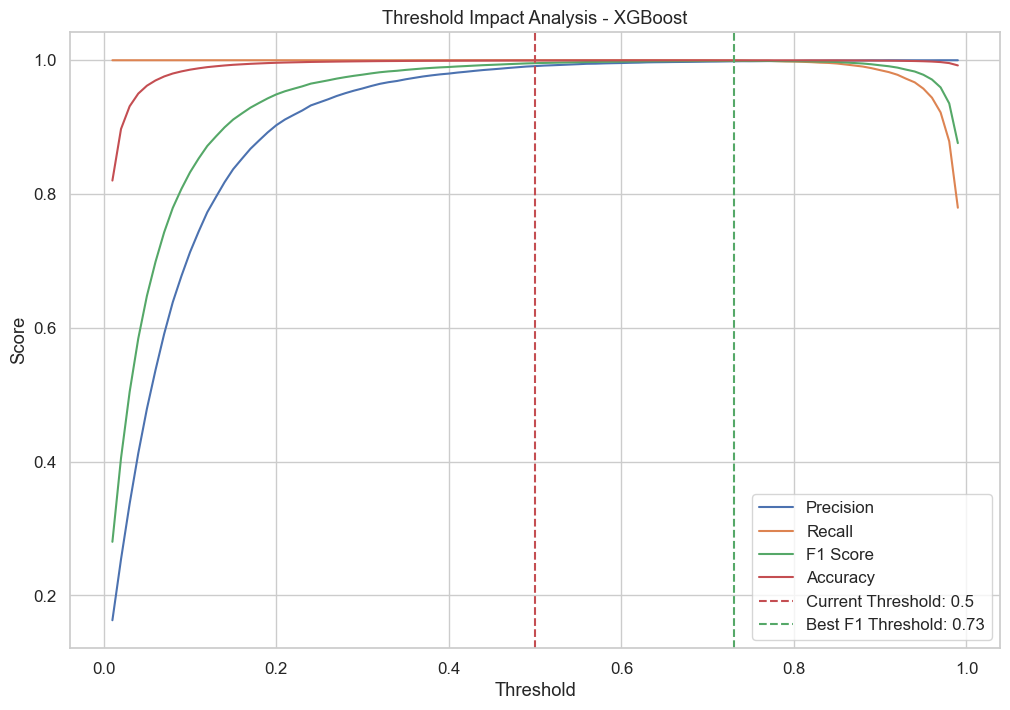

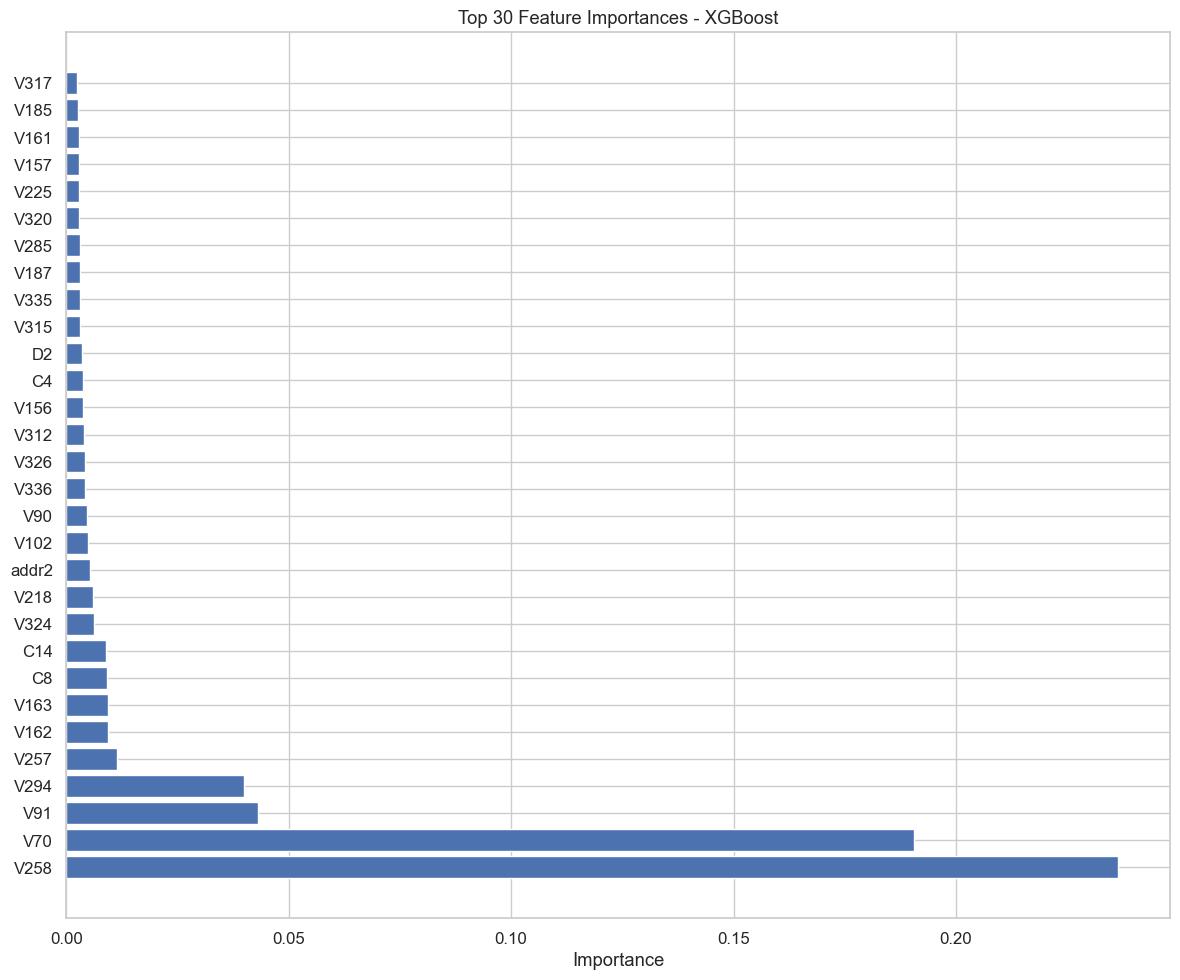

{'validation': {'auc': np.float64(0.999999604833298),
  'accuracy': 0.9996909608155248,
  'precision': 0.9912449028544016,
  'recall': 1.0,
  'f1': 0.9956032042401975,
  'log_loss': 0.009970003150722563,
  'brier_score': np.float64(0.0008626761313994915),
  'average_precision': np.float64(0.9999889357604116),
  'confusion_matrix': array([[455756,    146],
         [     0,  16530]]),
  'classification_report': {'0': {'precision': 1.0,
    'recall': 0.9996797557369785,
    'f1-score': 0.9998398522252863,
    'support': 455902.0},
   '1': {'precision': 0.9912449028544016,
    'recall': 1.0,
    'f1-score': 0.9956032042401975,
    'support': 16530.0},
   'accuracy': 0.9996909608155248,
   'macro avg': {'precision': 0.9956224514272007,
    'recall': 0.9998398778684893,
    'f1-score': 0.9977215282327418,
    'support': 472432.0},
   'weighted avg': {'precision': 0.9996936664836067,
    'recall': 0.9996909608155248,
    'f1-score': 0.9996916154606439,
    'support': 472432.0}}},
 'test': {'

In [63]:
evaluate_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="XGBoost",
    class_names=["Not Fraud", "Fraud"],
)

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming you already have X_train and y_train (use your own dataset here)
# Split the data for train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Calculate scale_pos_weight
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Define the XGBoost model with hyperparameters
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=17,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',
    use_label_encoder=False,
    missing=-999,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
)

# Early stopping callback during training
eval_set = [(X_train, y_train), (X_val, y_val)]  # Training and validation sets for monitoring
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=True
)

# Check performance on validation set
y_pred_val = model.predict(X_val)
y_proba_val = model.predict_proba(X_val)[:, 1]  # Probability for class 1

# Evaluate performance metrics on the validation set
print("Validation Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_val):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_val):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_val):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_proba_val):.4f}")

# Assuming you have X_test and y_test for evaluation
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)[:, 1]  # Probability for class 1

# Evaluate performance metrics on the test set
print("\nTest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba_test):.4f}")


c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:23:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-auc:0.94523	validation_1-auc:0.82125
[1]	validation_0-auc:0.96614	validation_1-auc:0.85161
[2]	validation_0-auc:0.97960	validation_1-auc:0.87912
[3]	validation_0-auc:0.98370	validation_1-auc:0.88820
[4]	validation_0-auc:0.98402	validation_1-auc:0.89282
[5]	validation_0-auc:0.98461	validation_1-auc:0.89467
[6]	validation_0-auc:0.98454	validation_1-auc:0.89496
[7]	validation_0-auc:0.98570	validation_1-auc:0.89830
[8]	validation_0-auc:0.98633	validation_1-auc:0.90066
[9]	validation_0-auc:0.98620	validation_1-auc:0.90101
[10]	validation_0-auc:0.98713	validation_1-auc:0.90339
[11]	validation_0-auc:0.98793	validation_1-auc:0.90482
[12]	validation_0-auc:0.98887	validation_1-auc:0.90834
[13]	validation_0-auc:0.98895	validation_1-auc:0.90887
[14]	validation_0-auc:0.98934	validation_1-auc:0.90937
[15]	validation_0-auc:0.98959	validation_1-auc:0.90993
[16]	validation_0-auc:0.99024	validation_1-auc:0.91087
[17]	validation_0-auc:0.99066	validation_1-auc:0.91103
[18]	validation_0-au

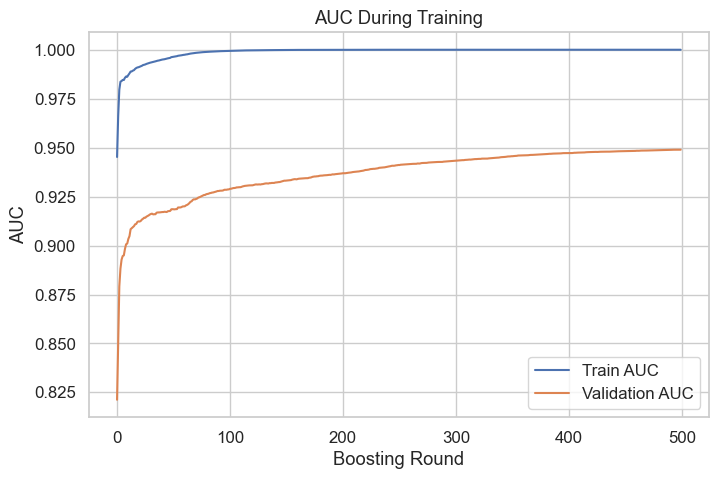

In [22]:
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
plt.plot(range(epochs), results['validation_0']['auc'], label='Train AUC')
plt.plot(range(epochs), results['validation_1']['auc'], label='Validation AUC')
plt.xlabel('Boosting Round')
plt.ylabel('AUC')
plt.title('AUC During Training')
plt.legend()
plt.show()


## XGBoost with K Cross Validation

In [11]:
from xgboost import XGBClassifier
from cross_validation import cross_validate_model

model = XGBClassifier(
    n_estimators=500,
    max_depth=17,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    scale_pos_weight=sum(y_train == 0) / sum(y_train == 1)
)

cross_validate_model(model, X_train, y_train, X_test, y_test, epochs=4)


🚀 Fold 1/4


c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:56:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1 - Recall: 0.6909486931268151
Fold 1 - Precision: 0.8989294710327456
Fold 1 - F1 Score: 0.7813355227148331

🚀 Fold 2/4


c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:01:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 - Recall: 0.6839303000968054
Fold 2 - Precision: 0.9127906976744186
Fold 2 - F1 Score: 0.7819590481460985

🚀 Fold 3/4


c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:06:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3 - Recall: 0.6963464795548028
Fold 3 - Precision: 0.9002189552705662
Fold 3 - F1 Score: 0.7852660300136426

🚀 Fold 4/4


c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:11:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4 - Recall: 0.6861843697072345
Fold 4 - Precision: 0.9011757229107086
Fold 4 - F1 Score: 0.7791208791208791

📊 Final OOF Evaluation:
OOF Recall: 0.6893526920750151
OOF Precision: 0.9032181357006975
OOF F1 Score: 0.7819254786248542

🧪 Final Test Evaluation:
Test Recall: 0.7067505443987419
Test Precision: 0.9197103274559194
Test F1 Score: 0.7992885483650294
Test ROC AUC: 0.9721155894220609


## Searching best combination of Feature Engineering Pipeline 

In [12]:
config = {
    'drop_low_information_columns': True,
    'drop_transaction_dt': True,
    'encode_categorical_columns': True,
    'fill_missing_values': True,
    'create_transaction_amount_ratios': False,
    'group_rare_categories': False,
    'create_time_features': False,
    'drop_unused_columns': True,
    'log_transform_transaction_amt': False
}


X_train_processed = run_feature_engineering_single_df(X_train.copy(), config)
X_test_processed = run_feature_engineering_single_df(X_test.copy(), config)

f1 = evaluate_model(X_train_processed, X_test_processed, model, y_train, y_test)
print(f"✅ F1-score: {f1}")

🚧 Starting feature engineering pipeline...

✅ Low-information columns dropped
✅ Data cleaned
✅ Categorical columns encoded
✅ Missing values filled
✅ Unused columns dropped
✅ Numeric features standardized
🎯 Final shape: (472432, 397)
🚧 Starting feature engineering pipeline...

✅ Low-information columns dropped
✅ Data cleaned
✅ Categorical columns encoded
✅ Missing values filled
✅ Unused columns dropped
✅ Numeric features standardized
🎯 Final shape: (118108, 397)


c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:15:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


KeyboardInterrupt: 